Use autoencoder to smooth values


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%tensorflow_version 2.x
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras import Input, Model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing

TensorFlow 2.x selected.


In [0]:
# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0


# define paths
output_path = '/content/drive/My Drive/Fax/Master Theses/output-LSTM-Autoencoder-1-2'
model_path = output_path+'/model.h5'

data_path = '/content/drive/My Drive/Fax/Master Theses/Data/CMAPSSData/'
autoencoder_path = '/content/drive/My Drive/Fax/Master Theses/output-autoencoder/model.h5'
encoder_path = '/content/drive/My Drive/Fax/Master Theses/output-autoencoder/encoder.h5'

In [0]:
##################################
# Data Ingestion
##################################

# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv(data_path+'train_FD001.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv(data_path+'test_FD001.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv(data_path+'RUL_FD001.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)



In [0]:
#######
# TRAIN set
#######
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

# generate label columns for training data
# we will only make use of "label1" for binary classification, 
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

#train_df.to_csv('../../Dataset/PredictiveManteinanceEngineTraining.csv', encoding='utf-8',index = None)

In [8]:
######
# TEST set
######
# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
print(test_df.head())

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

#test_df.to_csv('../../Dataset/PredictiveManteinanceEngineValidation.csv', encoding='utf-8',index = None)


   id  cycle  setting1  setting2  ...  s19       s20       s21  cycle_norm
0   1      1  0.632184  0.750000  ...  0.0  0.558140  0.661834     0.00000
1   1      2  0.344828  0.250000  ...  0.0  0.682171  0.686827     0.00277
2   1      3  0.517241  0.583333  ...  0.0  0.728682  0.721348     0.00554
3   1      4  0.741379  0.500000  ...  0.0  0.666667  0.662110     0.00831
4   1      5  0.580460  0.500000  ...  0.0  0.658915  0.716377     0.01108

[5 rows x 27 columns]


In [9]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

train_x = train_df[sequence_cols].values.astype(np.float32)
print(train_x.shape)

(20631, 25)


In [0]:
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [0]:

#load encoder
def get_autoencoded_data(data, print_model_data):
  if os.path.isfile(autoencoder_path):

      # restore weights

      autoencoder_model = load_model(autoencoder_path,custom_objects={'r2_keras': r2_keras,'root_mean_squared_error': root_mean_squared_error })

      encoded_data = autoencoder_model.predict(data,verbose=1, batch_size=200)
      if print_model_data:
        print(autoencoder_model.summary())
      return encoded_data

In [17]:
sequence_cols

['setting1',
 'setting2',
 'setting3',
 'cycle_norm',
 's1',
 's2',
 's3',
 's4',
 's5',
 's6',
 's7',
 's8',
 's9',
 's10',
 's11',
 's12',
 's13',
 's14',
 's15',
 's16',
 's17',
 's18',
 's19',
 's20',
 's21']

In [12]:
##create encoded sequence data

# pick a window size
sequence_length = 50

# = ['id', 's1', 's2', 's3','s4', 's5', 's6', 's7', 's8']
#get encoded data first
encoded_data = get_autoencoded_data(train_x, True)
# Convert the dictionary into DataFrame 
encoded_train = pd.DataFrame(encoded_data) 
  
#add column names
encoded_train.columns = sequence_cols
# Using DataFrame.insert() to add a column 
encoded_train.insert(0, "id", train_df['id'], True) 

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length):
    
    data_matrix = id_df[sequence_cols].values
    num_elements = data_matrix.shape[0]
    
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        

# generator for the sequences
# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(encoded_train[encoded_train['id']==id], sequence_length)) 
          for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

20631/20631 [==============================] - 0s 20us/sample
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 25)]              0         
_________________________________________________________________
dense_24 (Dense)             (None, 32)                832       
_________________________________________________________________
dense_25 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_26 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_27 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_28 (Dense)             (None, 32)                544       
_______________________________________________________________

In [13]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

In [14]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]
(sequence_length, nb_features)

(50, 25)

In [20]:
##################################
# Modeling
##################################

# Next, we build a deep network. 
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 
# Dropout is also applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and linear activation since this is a regression problem.
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras,root_mean_squared_error])
#model.compile(loss=root_mean_squared_error, optimizer='rmsprop',metrics=['mae',r2_keras,root_mean_squared_error])
print(model.summary())

# fit the network
history = model.fit(seq_array, label_array, epochs=200, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50, 100)           50400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
__________________________________________________

dict_keys(['loss', 'mae', 'r2_keras', 'root_mean_squared_error', 'val_loss', 'val_mae', 'val_r2_keras', 'val_root_mean_squared_error'])


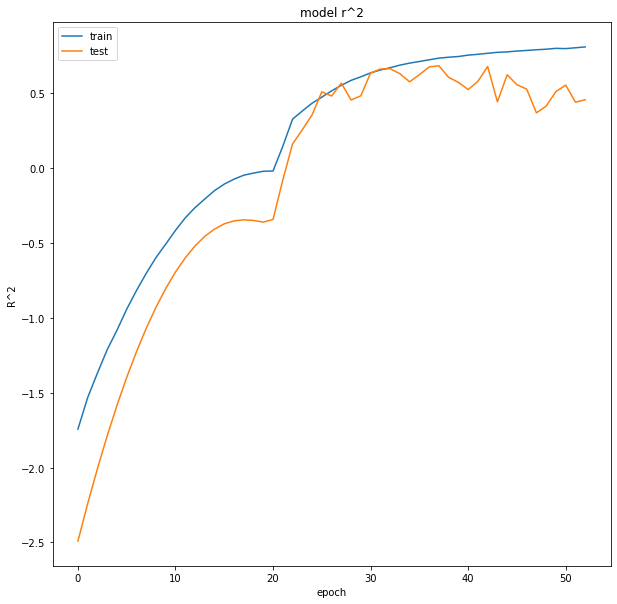

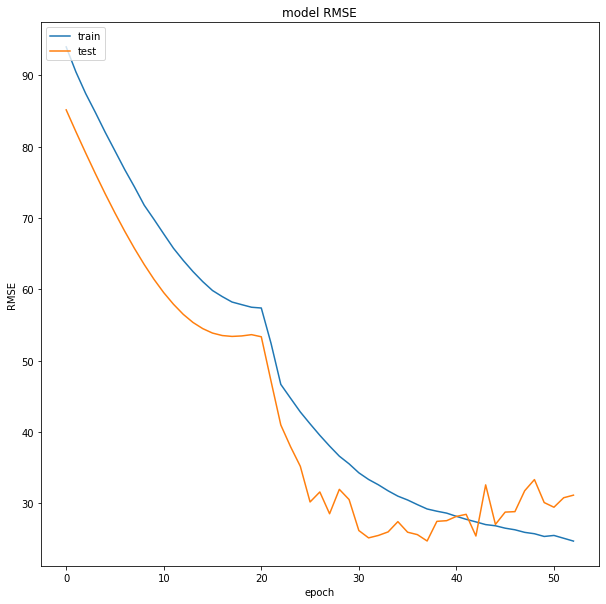

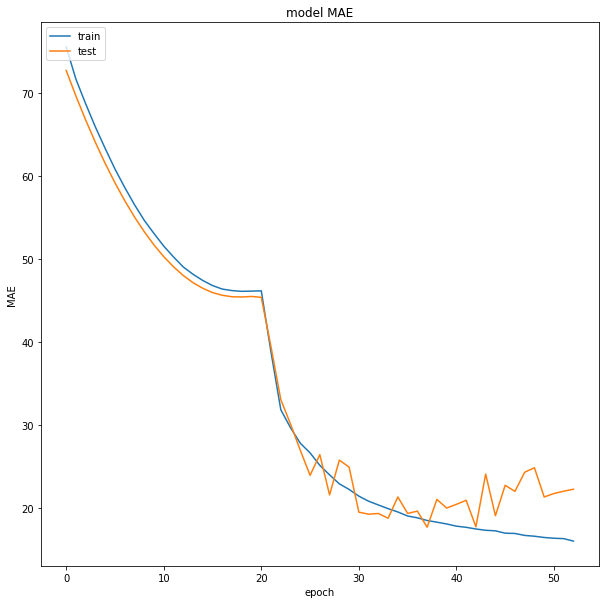

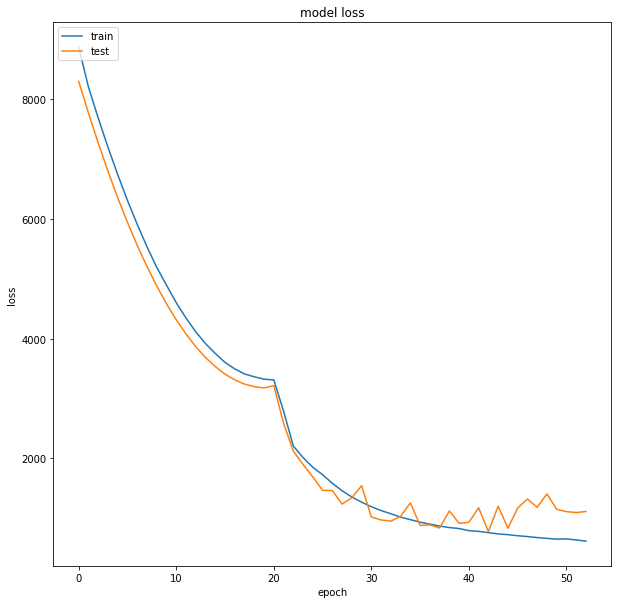

15631/15631 [==============================] - 0s 28us/sample - loss: 587.3049 - mae: 15.6559 - r2_keras: 0.7651 - root_mean_squared_error: 21.3437

MAE: 15.65594482421875

R^2: 0.7651131749153137
15631/15631 [==============================] - 1s 48us/sample


In [21]:

# list all data in history
print(history.history.keys())

# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(output_path+"/model_r2.png")

# summarize history for RMSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(output_path+"/model_RMSE.png")

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(output_path+"/model_mae.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(output_path+"/model_regression_loss.png")

# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv(output_path+'/submit_train.csv', index = None)


In [22]:

test_x = test_df[sequence_cols].values.astype(np.float32)
print(test_x.shape)
#get encoded data first
encoded_data_test = get_autoencoded_data(test_x, False)
# Convert the dictionary into DataFrame 
encoded_test = pd.DataFrame(encoded_data_test) 


#add column names
encoded_test.columns = sequence_cols

# Using DataFrame.insert() to add a column 
encoded_test.insert(0, "id", test_df['id'], True) 

(13096, 25)
13096/13096 [==============================] - 0s 9us/sample


seq_array_test_last
(93, 50, 25)
(93, 1)
93/93 - 0s - loss: 366.9622 - mae: 14.2754 - r2_keras: 0.7771 - root_mean_squared_error: 19.1650

MAE: 14.27540397644043

R^2: 0.7771084904670715

RMSE: 19.1650447845459


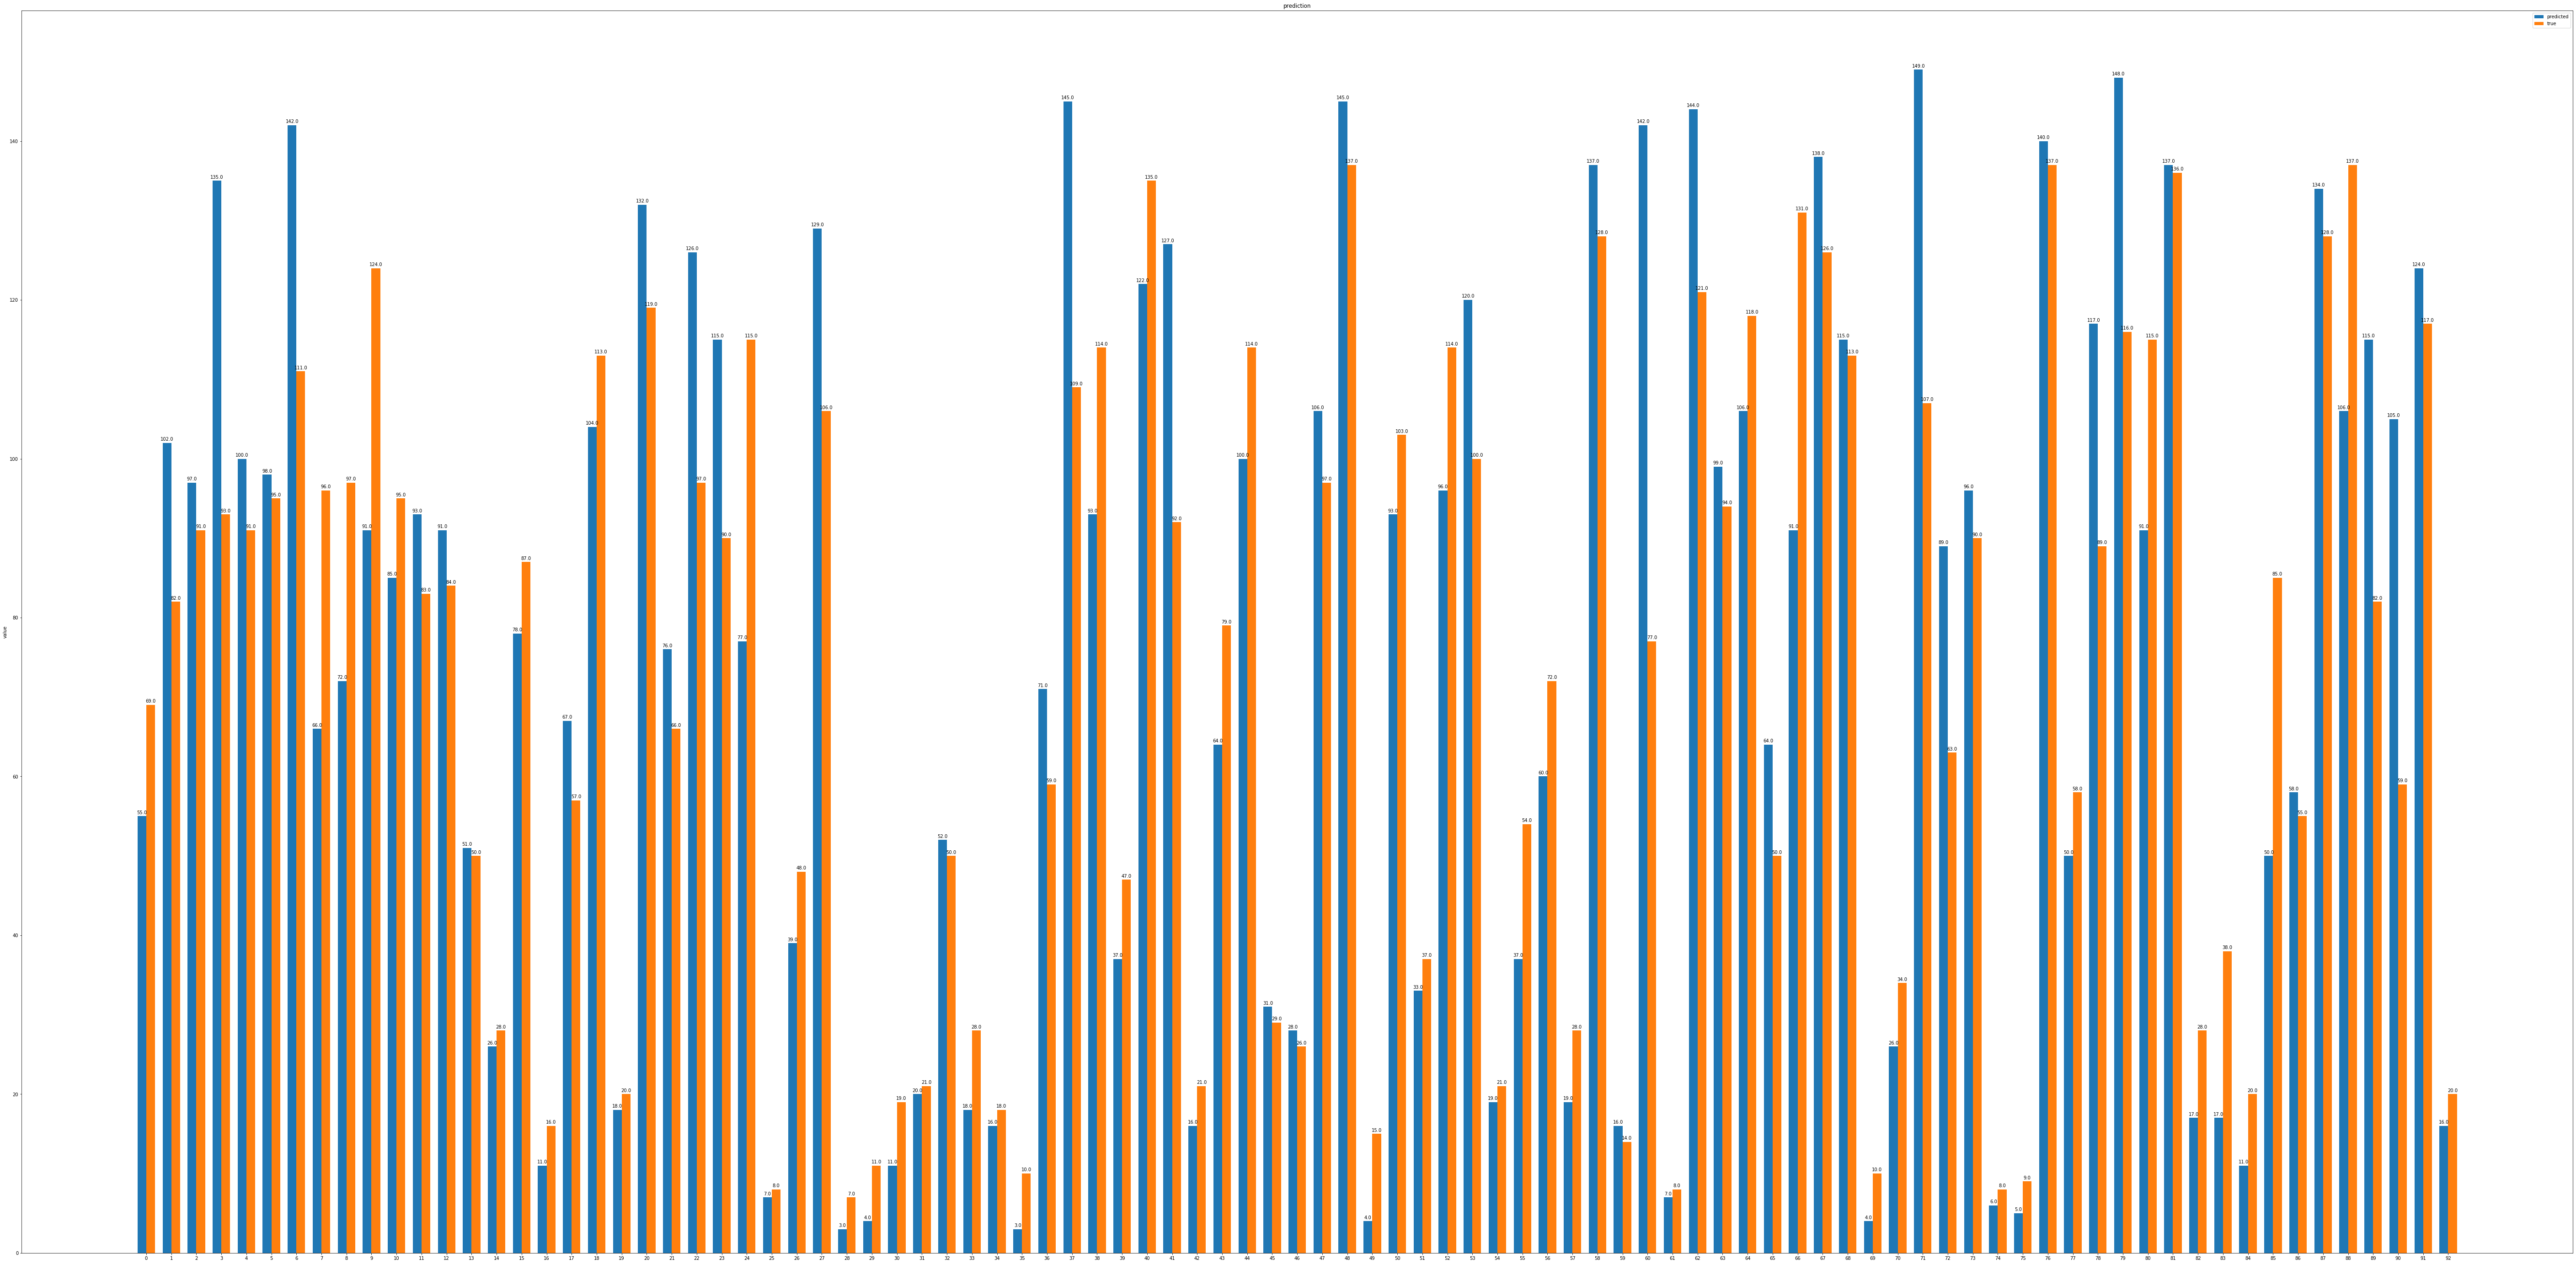

In [23]:
##################################
# EVALUATE ON TEST DATA
##################################

# We pick the last sequence for each id in the test data
seq_array_test_last = [encoded_test[encoded_test['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in encoded_test['id'].unique() if len(encoded_test[encoded_test['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
print("seq_array_test_last")
print(seq_array_test_last.shape)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print(label_array_test_last.shape)


# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras, 'root_mean_squared_error':root_mean_squared_error})

    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))
    print('\nRMSE: {}'.format(scores_test[3]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv(output_path+'/submit_test.csv', index = None)

    #######################
    # Plot in blue color the predicted data and in orange color the
    # actual data to verify visually the accuracy of the model.
        
    x = np.arange(len(y_pred_test))
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(100, 50))
    rects1 = ax.bar(x - width/2, y_pred_test.flatten().round(), width, label='predicted')
    rects2 = ax.bar(x + width/2, y_true_test.flatten(), width, label='true')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('value')
    ax.set_title('prediction')
    ax.set_xticks(x)
    ax.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

    plt.show()
    fig.savefig(output_path+"/model_verify_bar.png")